<a href="https://colab.research.google.com/github/ADnnx/mIA/blob/master/Multivariado/GRU_multivar_QAir_TS_Predic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TFM: 
Predicción de la calidad del aire en Medellín (Colombia) usando Inteligencia Artificial sobre datos abiertos 

: Álvaro Bedoya \
UNIR


## Importación de librerias

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean 


## Cargue de datos



In [ ]:
# Cargar datos 
# /content/drive/My Drive/ 
from google.colab import drive
drive.mount('/content/drive/')
data_dir = "/content/drive/My Drive/Colab Notebooks/Data/Siata/"
infile="multivar_estacion-25_2016-2019.csv"
df = pd.read_csv(data_dir+infile, header=0, parse_dates=[0], index_col=0)
# Guardar una copia para comparaciones
df_org = df.copy()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Caractristicas del conjunto de datos, señales registradas de contaminantes

In [ ]:
df.head()

,PM25,O3,NO,NO2,NOx
FECHA,,,,,
2016-01-01 00:00:00,36.0,13.0,2.0,16.0,18.0
2016-01-01 01:00:00,70.0,13.0,1.0,15.0,16.0
2016-01-01 02:00:00,53.0,9.0,4.0,18.0,22.0
2016-01-01 03:00:00,52.0,4.0,10.0,21.0,31.0
2016-01-01 04:00:00,53.0,2.0,13.0,20.0,34.0


### Previsualización de señales

Puede observar "un valle" en la series de tiempo de las señal PM2.5 y O3 debido a la imputación de datos en la etapa de  preprocesamiento, al tratar la calidad deficiente del dato.

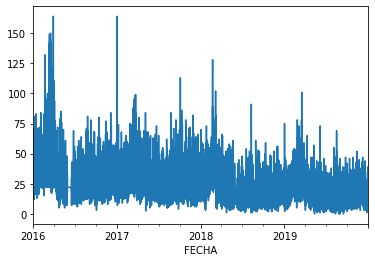

In [ ]:
df['PM25'].plot();

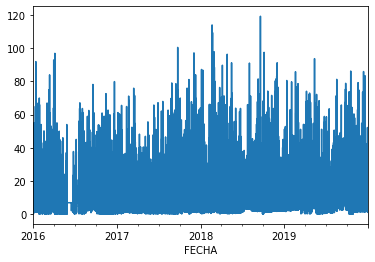

In [ ]:
df['O3'].plot();

In [ ]:
# Cantidad de observaciones de la señal PM2.5
df.values.shape

(35064, 5)

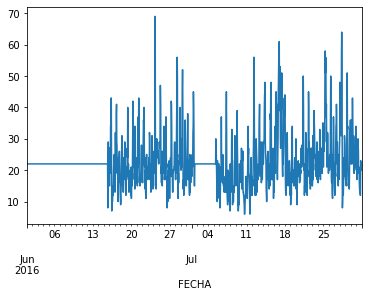

In [ ]:
df['PM25']['2016-06':'2016-07'].plot();



Para conocer la cronologia del registro de la señal en el periodo de un año, se agrega el día del año (de 1 a 365) y la hora del día (de 0 a 23) a las señales de entrada. Ya que el conjunto de datos contiene la información de fecha y hora estampada para cada observación, pero, solo se usa en el índice para ordenar los datos.

In [ ]:
df['Dia'] = df.index.dayofyear
df['Hora'] = df.index.hour

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2016-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM25    35064 non-null  float64
 1   O3      35064 non-null  float64
 2   NO      35064 non-null  float64
 3   NO2     35064 non-null  float64
 4   NOx     35064 non-null  float64
 5   Dia     35064 non-null  int64  
 6   Hora    35064 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 3.4 MB
None


In [ ]:
print(df.head())

                     PM25    O3    NO   NO2   NOx  Dia  Hora
FECHA                                                       
2016-01-01 00:00:00  36.0  13.0   2.0  16.0  18.0    1     0
2016-01-01 01:00:00  70.0  13.0   1.0  15.0  16.0    1     1
2016-01-01 02:00:00  53.0   9.0   4.0  18.0  22.0    1     2
2016-01-01 03:00:00  52.0   4.0  10.0  21.0  31.0    1     3
2016-01-01 04:00:00  53.0   2.0  13.0  20.0  34.0    1     4


In [ ]:
print(df.tail())

                     PM25   O3       NO      NO2       NOx  Dia  Hora
FECHA                                                                
2019-12-31 19:00:00  12.0  0.9  45.4879  21.7711   67.2590  365    19
2019-12-31 20:00:00  13.0  1.3  39.1161  20.6367   59.7528  365    20
2019-12-31 21:00:00  18.0  1.6  82.3009  21.1742  103.4751  365    21
2019-12-31 22:00:00  24.0  1.5  85.3961  19.0080  104.4041  365    22
2019-12-31 23:00:00  31.0  1.5  71.2671  13.4446   84.7117  365    23


# Objetivo para la predicción

Definir la señal objectivo a PM25 para predecir la calidad del aire basado en el contaminante de material particulado de 2.5 micras.

In [ ]:
predictor_Y = ['PM25']


# Preparar los periodos de tiempo
Los pronósticos se basan en un período de tiempo (t+1) avanzado al período de tiempo de las observaciones (t). Los datos reales del pronóstico de la variable dependiente no figuran en la muestra. 

Para predecir el indice de PM2.5 en las siguientes 24 horas, cambiamos los datos en 24 pasos de tiempo. Por ejemplo, predecir los proximos 7 días se desplazan los datos 7 * 24 pasos de tiempo.

El conjunto de datos se vuelve a muestrear para tener 24 observaciones durante un dia, una cada hora.



In [ ]:
dias = 1 # Cantidad de dias a predecir
pasos = dias * 24 # Datos desplazados en peridods de tiempo equivalente a cantidad de horas

Se crea un marco de datos con la señal objetivo de los datos diferidos en el tiempo en sentido negativo, porque Pandas mantiene las marcas de tiempo originales al remuestrearlos.


In [ ]:
df_targets = df[predictor_Y].shift(-pasos)

In [ ]:
# Estos son las primeras 29 filas del marco de datos original para PM2.5
df[predictor_Y].head(pasos + 5)

,PM25
FECHA,
2016-01-01 00:00:00,36.0
2016-01-01 01:00:00,70.0
2016-01-01 02:00:00,53.0
2016-01-01 03:00:00,52.0
2016-01-01 04:00:00,53.0
2016-01-01 05:00:00,46.0
2016-01-01 06:00:00,40.0
2016-01-01 07:00:00,34.0
2016-01-01 08:00:00,36.0


Despliegue de las primeras 5 filas del nuevo marco de datos objetivos diferido en el tiempo. 
Observar que el valor PM25 de las últimas 5 filas de los datos originales,  son iguales a los datos objetivos, excepto por la marca de tiempo ya que Pandas mantiene las marcas de tiempo originales.

In [ ]:
df_targets.head(5)

,PM25
FECHA,
2016-01-01 00:00:00,26.0
2016-01-01 01:00:00,25.0
2016-01-01 02:00:00,14.0
2016-01-01 03:00:00,26.0
2016-01-01 04:00:00,25.0



Debido al desplazado hacia atrás en el marco de datos objetivo las últimas observaciones son "NaN", porque se ha tratando de cambiar los datos que no existen en el marco de datos original.

In [ ]:
df_targets.tail()

,PM25
FECHA,
2019-12-31 19:00:00,NaN
2019-12-31 20:00:00,NaN
2019-12-31 21:00:00,NaN
2019-12-31 22:00:00,NaN
2019-12-31 23:00:00,NaN


Crea el vector de entrada a la red neuronal con las señales de los contaminantes

In [ ]:
x_data = df.values[0:-pasos]

Crea el vector de salida de la red neuronal para la predicción de PM2.5 

In [ ]:
y_data = df_targets.values[:-pasos]

Separar el 90% de los datos para el conjunto de entrenamiento y el resto para el conjunto de pruebas.

In [ ]:
num_data = len(x_data)
num_train = int(0.9 * num_data)
num_test = num_data - num_train

31536

Vector de señales de entrada para el conjunto de entrenamiento y conjunto de pruebas

In [ ]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

35040

Vector de señales de salida para el conjunto de entrenamiento y conjunto de pruebas

In [ ]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

35040

Asignación de la cantidad de señales de entrada y señales de salidad para el generador de lotes 

In [ ]:
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

7

Normalizar o escalar los datos a valores entre -1 y 1


In [ ]:
# Escalado en las señales de entrada tanto en el conjunto de entrenamiento como en el conjunto de pruebas
x_scaler = MinMaxScaler() 
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)       
# Escalado en las señal de salida tanto en el conjunto de entrenamiento como en el conjunto de pruebas
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Los datos se ha preparado como dos matrices numéricas bidimensionales para 31536 observaciones, una con 7 señales de entrada y otra con una señal de salida.


Generarción de lotes de subsecuencias más cortas seleccionadas al azar de los datos de entrenamiento. 


In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
#C7 Ajuste del tamaño de lote para la carga de trabajo.
batch_size = 256  # Mantiene la GPU cerca del 100% de computación cloud
#batch_size = 50  # Tamaño para el uso de CPU de PC


In [ ]:
#C8 Ajuste de la longitud de secuencia, Un intervalo de tiempo corresponde a una hora, 24 x 7 intervalos de tiempo corresponden a una semana
sequence_length = 24 * 7 * 4  # 4 Semanas


672

In [ ]:
#C9 Función para generar los lotes de trabajo.
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [ ]:
#C10 Generar lotes.
x_batch, y_batch = next(generator)

In [ ]:
#C11 Se ha producido un lote aleatorio de 256 secuencias, cada secuencia tiene 672 observaciones y cada observación tiene 7 señales de entrada y 1 señal de salida. 
print(x_batch.shape)
print(y_batch.shape)

(256, 672, 7)
(256, 672, 1)


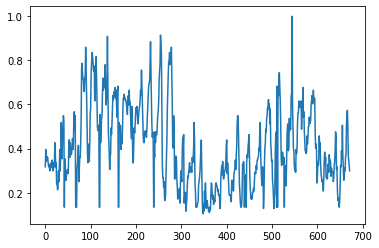

In [ ]:
#C12 Trazado de las señales de entrada.
batch = 0   
signal = 0  
seq = x_batch[batch, :, signal]
plt.plot(seq)

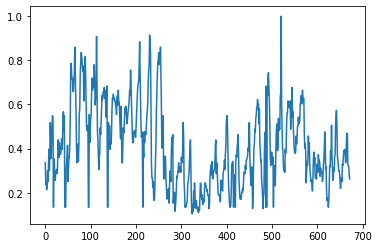

In [ ]:
#C13 Trazado de la señal de salida que queremos que el modelo aprenda a predecir dadas las señales de entrada.
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [ ]:
#C14 Conformar los datos de validacion en una matriz ampliada 
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
#C15 Crear la red neuronal recurrente (RNN)
model = Sequential()

In [ ]:
#C16 Agregar una unidad recurrente cerrada (GRU) a la red, con 512 salidas para cada paso de tiempo en la secuencia.
"""En la primera capa del modelo la forma de su entrada es un lote de secuencias de longitud arbitraria, donde cada observación tiene un número de señales de entrada (num_x_signals)
según la Api de Keras."""
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [ ]:
#C17 Para predecir 1 señal de salida, agregamos una capa completamente conectada (o densa)
# utilizando la función de activación Sigmoid, que aplana la salida para que esté entre 0 y 1. 
model.add(Dense(num_y_signals, activation='sigmoid'))

In [ ]:
#C18 
# Genera tensores con distribución uniforme.
# usar una función de activación lineal en la salida
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [ ]:
#C19 Establecer el error cuadrático medio (MSE) como la función de pérdida.
# Mide qué tan cerca esta la salida del modelo con las señales de salida reales.
# al comienzo de una secuencia, el modelo solo ha visto señales de entrada durante unos pocos pasos de tiempo, por lo que su salida generada puede ser muy inexacta
# con un 'período de calentamiento' de 50 pasos de tiempo donde no usamos su precisión en la función de pérdida, para mejorar la precisión para pasos de tiempo posteriores.
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [ ]:
#C20 Establecer la tasa de aprendizaje inicial para el optimizador adaptativo
# Root Mean Square Propagation (RMSprop).
optimizer = RMSprop(lr=1e-3)

In [ ]:
#C21 Compilación del modelo preparandolo para el entrenamiento. 
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [ ]:
#C22 El modelo consta de dos capas, a la salida una señal objetivo de predicción.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         800256    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 800,769
Trainable params: 800,769
Non-trainable params: 0
_________________________________________________________________


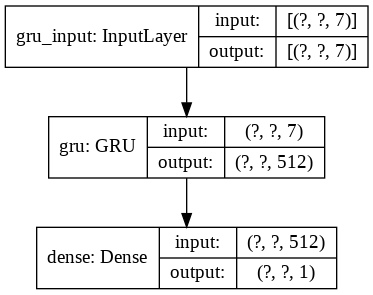

In [ ]:
#C22b
from tensorflow import keras
keras.utils.plot_model(model, "Forma_RNN_shape_info.png", show_shapes=True)

In [ ]:
#C23 Funciones de devolución de llamada
# Durante el entrenamiento se guardan puntos de control y registro del progreso en TensorBoard.
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
#C24 Devolución de parada prematura para evita el sobreentrenamiento.
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [ ]:
#C25 Devolución de llamada para escribir el registro de TensorBoard
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
#C26 Devolución de llamada que reduce la tasa de aprendizaje para el optimizador si la pérdida de validación no ha mejorado desde la última época (patience = 0)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
#C26b Todas las devoluciones de llamada
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [ ]:
#C27 Entrenamiento de la red neuronal recurrente
# por cada pasos de epoca se procesan pequeños lotes generados aleatoriamente del conjunto de datos de entrenamiento.
%%time 
epocas_p=20  #5
pasos_epoca_p=100 #10
model.fit(x=generator,
          epochs=epocas_p,
          steps_per_epoch=pasos_epoca_p,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
  1/100 [..............................] - ETA: 0s - loss: 0.1273WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.0094
Epoch 00001: val_loss improved from inf to 0.00473, saving model to 23_checkpoint.keras
100/100 [==============================] - 34s 345ms/step - loss: 0.0094 - val_loss: 0.0047
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0053
Epoch 00002: val_loss improved from 0.00473 to 0.00307, saving model to 23_checkpoint.keras
100/100 [==============================] - 36s 356ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0047
Epoch 00003: val_loss did not improve from 0.00307

Epoch 0000

In [ ]:
#C28 Recargar el último punto de control guardado del mejor rendimiento en el conjunto de prueba. 
# Si hubiera una parada temprana al entrenar el modelo, si el rendimiento del modelo haya empeorado en el conjunto de prueba durante varias épocas antes de que se detuviera el entrenamiento
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
#C29 Evaluación del rendimiento del moelo en el conjunto de prueba
# SE expande la dimensionalidad de la matriz para crea un lote con la secuecnia se la serie de tiempo
x=np.expand_dims(x_test_scaled, axis=0)
y=np.expand_dims(y_test_scaled, axis=0)
result = model.evaluate(x, y)

1/1 [==============================] - 0s 1ms/step - loss: 0.0020


In [ ]:
print("loss (test-set):", result)

loss (test-set): 0.001958788139745593


In [ ]:

print(model.metrics_names) 


['loss']


In [ ]:
# # Si tiene varias métricas, puede usar esta en su lugar.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [ ]:
#C30 Generar predicciones
# y trazar las señales de salida predichas. 
def plot_comparison(start_idx, length=100, train=True):
    """
    Trazado de las señales de salida predichas y verdaderas.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
        Data_Label = 'Train data set'
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
        Data_Label = 'Test data set'
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label=Data_Label)
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

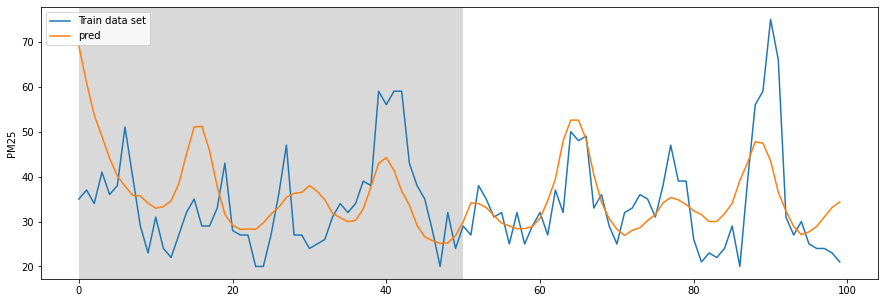

In [ ]:
#C31 Trazado comparativo de señales de salida predichas y datos de entrenamiento. 
plot_comparison(start_idx=10000, length=100, train=True)

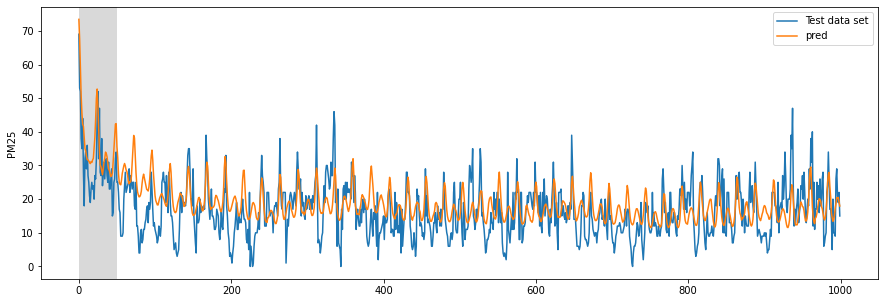

In [ ]:
#C32 Trazado comparativo de señales de salida predichas y datos de pruebas. 
# El modelo no ha visto estos datos durante el entrenamiento.
# La predicción del material particulado 2.5μm se muestra hacia la tendencia y la estacionalidad de los valores verdaderos del conjunto de datos de prueba, prudentemente bien.
plot_comparison(start_idx=200, length=1000, train=False)